### <font color="red">Before training, run the following bash command!!!</font>

In [1]:
#Will allow you to go past jupyter session timeout
#!launch-scipy-ml-gpu.sh K8S_TIMEOUT_SECONDS=43200 -b

In [2]:
from torchvision import utils
from basic_fcn import *
from dataloader2 import *
from utils import *
import torchvision
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import time
import matplotlib.pyplot as plt

In [3]:
# Update this for your model
best_model_name = "basic_fcn_model_unweighted"

In [4]:
training_batch = 4
val_batch = 4
test_batch = 1
train_dataset = CityScapesDataset(csv_file='train.csv', transforms = ['hflip', 'rotation'], resize_factor = 0.5)
val_dataset = CityScapesDataset(csv_file='val.csv')
test_dataset = CityScapesDataset(csv_file='test.csv')
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=training_batch,
                          num_workers=4,
                          shuffle=True)
val_loader = DataLoader(dataset=val_dataset,
                          batch_size=val_batch,
                          num_workers=4,
                          shuffle=True)
test_loader = DataLoader(dataset=test_dataset,
                          batch_size=test_batch,
                          num_workers=4,
                          shuffle=False)

In [6]:
def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.xavier_uniform_(m.weight.data)
        torch.nn.init.xavier_uniform_(m.bias.data.unsqueeze(0)) #add unsqueeze here 

In [7]:
def train0(model, loss_fn, weights=None):
    print("Training Epoch 0")
    
    model.eval()
    trainLoss = 0
    trainAcc = 0
    numIter = 0
    soMuchTension = torch.Tensor([0 for i in range(n_class)]) #intersection
    theresATigerInTheBathroom = torch.Tensor([0 for i in range(n_class)]) #union
    ts = time.time()
    
    for iter, (X, tar, Y) in enumerate(val_loader):
        numIter +=1
        if use_gpu:
            torch.cuda.empty_cache() 
            inputs = X.cuda()
            labels = Y.cuda()
        else:
            inputs, one_hot_labels, labels = X, tar, Y
        
        outputs = model(inputs)
        
        if weights == None:
            trainLoss += loss_fn(outputs, labels).item()
        
        else:
            trainLoss += weighted_cross_entropy(outputs, labels, weights).item()
        
        speakSoftlyAndCarryABigStick = F.softmax(outputs, dim = 1) #softmax along the number of class dimension
        del inputs, outputs
        
        indexes = torch.argmax(speakSoftlyAndCarryABigStick, dim = 1) #get the argmax along the channel dimension      
        del speakSoftlyAndCarryABigStick
        
        trainAcc += pixel_acc(indexes, labels)
        
        theEyesHaveIt, spaceBalls = iou(indexes, labels, n_class) #intersection, union
        del labels, indexes
        
        soMuchTension = soMuchTension + theEyesHaveIt
        del theEyesHaveIt
        
        theresATigerInTheBathroom = theresATigerInTheBathroom + spaceBalls
        del spaceBalls
        
        torch.cuda.empty_cache()
        
        #'''
        if iter == 2:
            break
        #'''
        
    iOweYouMoney = torch.div(soMuchTension, theresATigerInTheBathroom)
    del soMuchTension, theresATigerInTheBathroom
    
    print()
    trainAcc = trainAcc/numIter
    trainLoss = trainLoss/numIter
    print("epoch0, train loss: {}".format(trainLoss))
    print("epoch0, train accuracy: {}".format(trainAcc))
    print("The building IOU is: " + str(iOweYouMoney[11].item()))
    print("The traffic sign IOU is: " + str(iOweYouMoney[20].item()))
    print("The person IOU is: " + str(iOweYouMoney[24].item()))
    print("The car IOU is: " + str(iOweYouMoney[26].item()))
    print("The bicycle IOU is: " + str(iOweYouMoney[33].item()))
    print("The average IOU is: " + str(MeanIOU(iOweYouMoney)))
    print("Finish validation at epoch0, time elapsed {}".format(time.time() - ts))
    print("Current memory allocation:", torch.cuda.memory_allocated())
    print()
    return trainLoss, trainAcc, iOweYouMoney

In [8]:
def val(model, loss_fn, epoch, weights=None):

    print("Validation Epoch {}".format(epoch))
    
    model.eval()
    valLoss = 0
    valAcc = 0
    numIter = 0
    soMuchTension = torch.Tensor([0 for i in range(n_class)]) #intersection
    theresATigerInTheBathroom = torch.Tensor([0 for i in range(n_class)]) #union
    ts = time.time()
    
    for iter, (X, tar, Y) in enumerate(val_loader):
        numIter +=1
        if use_gpu:
            torch.cuda.empty_cache() 
            inputs = X.cuda()
            labels = Y.cuda()
        else:
            inputs, one_hot_labels, labels = X, tar, Y
            
        outputs = model(inputs)
        
        if weights == None:
            valLoss += loss_fn(outputs, labels).item()
        
        else:
            valLoss += weighted_cross_entropy(outputs, labels, weights).item()
        
        speakSoftlyAndCarryABigStick = F.softmax(outputs, dim = 1) #softmax along the number of class dimension
        del inputs, outputs
        
        indexes = torch.argmax(speakSoftlyAndCarryABigStick, dim = 1) #get the argmax along the channel dimension      
        del speakSoftlyAndCarryABigStick
        
        valAcc += pixel_acc(indexes, labels)
        theEyesHaveIt, spaceBalls = iou(indexes, labels, n_class) #intersection, union
        del labels, indexes
        
        soMuchTension = soMuchTension + theEyesHaveIt
        del theEyesHaveIt
        
        theresATigerInTheBathroom = theresATigerInTheBathroom + spaceBalls
        del spaceBalls
        
        torch.cuda.empty_cache()
        
        #'''
        if iter == 2:
            break
        #'''
        
    iOweYouMoney = torch.div(soMuchTension, theresATigerInTheBathroom)
    del soMuchTension, theresATigerInTheBathroom
    
    print()
    valAcc = valAcc/numIter
    valLoss = valLoss/numIter
    print("epoch{}, validation loss: {}".format(epoch, valLoss))
    print("epoch{}, validation accuracy: {}".format(epoch, valAcc))
    print("The building IOU is: " + str(iOweYouMoney[11].item()))
    print("The traffic sign IOU is: " + str(iOweYouMoney[20].item()))
    print("The person IOU is: " + str(iOweYouMoney[24].item()))
    print("The car IOU is: " + str(iOweYouMoney[26].item()))
    print("The bicycle IOU is: " + str(iOweYouMoney[33].item()))
    print("The average IOU is: " + str(MeanIOU(iOweYouMoney)))
    print("Finish validation at epoch{}, time elapsed {}".format(epoch, time.time() - ts))
    print("Current memory allocation:", torch.cuda.memory_allocated())
    print()
    return valLoss, valAcc, iOweYouMoney

In [9]:
def train(model, loss_fn, epochs, patience, weights=None):
    t_losses = []
    t_accuracies = []
    val_losses = []
    val_accuracies = []
    ious = []
    
    e_stop = False
    best_model = None
    stop = EarlyStop(patience)
    for epoch in range(1, epochs+1):
        
        print("Training Epoch {}".format(epoch))
        ts = time.time()
        
        numIter = 0
        epoch_train_loss = 0
        epoch_train_acc = 0
        
        for iter, (X, tar, Y) in enumerate(train_loader):
            numIter +=1
            optimizer.zero_grad()

            if use_gpu:
                torch.cuda.empty_cache() 
                inputs = X.cuda() # Move your inputs onto the gpu
                labels = Y.cuda()
            else:
                inputs, labels = X, Y # Unpack variables into inputs and labels

            outputs = model(inputs)
            del inputs
            
            if weights == None:
                loss = loss_fn(outputs, labels)         
                epoch_train_loss += loss.item()
        
            else:
                loss = weighted_cross_entropy(outputs, labels, weights)
                epoch_train_loss += loss.item()
            
            speakSoftlyAndCarryABigStick = F.softmax(outputs, dim = 1) #softmax along the number of class dimension
            del outputs
            
            indexes = torch.argmax(speakSoftlyAndCarryABigStick, dim = 1) #get the argmax along the channel dimension
            del(speakSoftlyAndCarryABigStick)
            
            epoch_train_acc += pixel_acc(indexes, labels)
            del indexes, labels
            
            loss.backward()
            optimizer.step()
            torch.cuda.empty_cache()    
            
            if iter % 100 == 0:
                print("epoch{}, iter{}, loss: {}".format(epoch, iter, loss.item()))
                  
            #'''
            if iter == 10:
                break
            #'''
              
        print("Finish epoch {}, time elapsed {}".format(epoch, time.time() - ts))
        print("epoch{}, training accuracy: {}".format(epoch, epoch_train_acc/numIter))
        print("Current memory allocation:", torch.cuda.memory_allocated()) 
        
        print()
        
        t_losses.append(epoch_train_loss/numIter)
        t_accuracies.append(epoch_train_acc/numIter)
        
        val_loss, val_acc, iou = val(model, loss_fn, epoch)
        
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        ious.append(iou)
        
        e_stop, best_model = stop(val_loss, model)
        if e_stop:
            torch.save(best_model.state_dict(), '{}.pt'.format(best_model_name))
            print("Early stopping at:", epoch)
            break
            
        model.train()
    
    if not e_stop:
        torch.save(best_model.state_dict(), '{}.pt'.format(best_model_name))
        
    return t_losses, t_accuracies, val_losses, val_accuracies, ious

Training Epoch 0

epoch0, train loss: 3.3791024684906006
epoch0, train accuracy: 0.1768672728473942
The building IOU is: 0.0
The traffic sign IOU is: 0.0
The person IOU is: 0.0
The car IOU is: 0.0
The bicycle IOU is: 0.0021240359637886286
The average IOU is: 0.00011800199798825715
Finish validation at epoch0, time elapsed 8.815700769424438
Current memory allocation: 22948352

Validation Epoch 0

epoch0, validation loss: 3.3773109118143716
epoch0, validation accuracy: 0.7677641779709387
The building IOU is: 0.0
The traffic sign IOU is: 0.0
The person IOU is: 0.0
The car IOU is: 0.0
The bicycle IOU is: 0.008892782032489777
The average IOU is: 0.0005231048254405751
Finish validation at epoch0, time elapsed 7.984322547912598
Current memory allocation: 22948352

Training Epoch 1
epoch1, iter0, loss: 3.4109368324279785
Finish epoch 1, time elapsed 5.155300617218018
epoch1, training accuracy: 29.357382048948047
Current memory allocation: 91330048

Validation Epoch 1

epoch1, validation loss: 

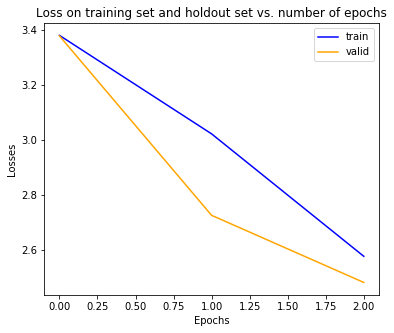

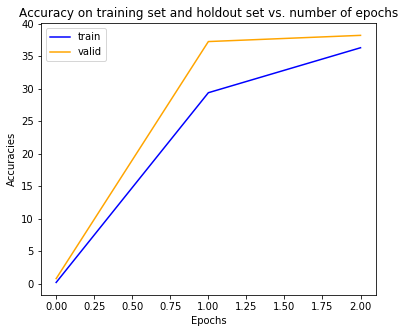

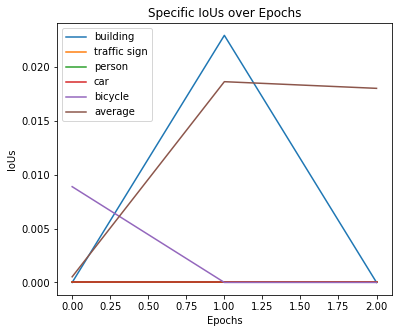

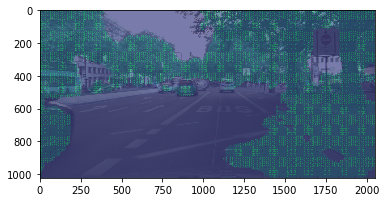

In [10]:
%%time

if __name__ == "__main__":
    
    epochs = 2
    be_patient = 5
    
    # Set up class weights to potentially use
    class_weights = torch.FloatTensor(1/np.load('total_pixel_weights.npy'))
    class_weights = n_class * class_weights/class_weights.sum()
    
    # Non-weighted vs weighted loss definition
    criterion = nn.CrossEntropyLoss()
    weighted_criterion = nn.CrossEntropyLoss(weight=class_weights)
    
    # Build model
    fcn_model = FCN(n_class=n_class)
    fcn_model.apply(init_weights)
    #fcn_model = torch.load('best_model')  # For when we have a best model to test
    optimizer = optim.Adam(fcn_model.parameters(), lr=5e-3)
    
    # Move model to gpu
    use_gpu = torch.cuda.is_available()
    if use_gpu:
        fcn_model = fcn_model.cuda()
    
    # Establish baseline metrics
    train_0 = train0(fcn_model, criterion)
    validation_0 = val(fcn_model, criterion, 0)  # show the accuracy before training
    
    # Train for epochs with patience
    training_losses, training_accuracies, validation_losses, validation_accuracies, validation_ious = train(fcn_model, criterion, epochs, be_patient)
        
    # Add in the baseline
    training_losses.insert(0, train_0[0])
    training_accuracies.insert(0, train_0[1])    
    validation_losses.insert(0, validation_0[0])
    validation_accuracies.insert(0, validation_0[1])
    validation_ious.insert(0, validation_0[2])
    
    # Plot loss and save fig
    fig,ax = plt.subplots(figsize=(6,5))
    ax.set_ylabel('Losses')
    ax.set_xlabel('Epochs')
    _=ax.plot(range(0, epochs+1), training_losses,'b-',color="blue",label="train")
    _=ax.plot(range(0, epochs+1), validation_losses,'b-',color="orange",label="valid")
    plt.legend()
    plt.title("Loss on training set and holdout set vs. number of epochs")
    plt.savefig('{}_loss.png'.format(best_model_name))
    
    # Plot loss and save fig
    fig,ax = plt.subplots(figsize=(6,5))
    ax.set_ylabel('Accuracies')
    ax.set_xlabel('Epochs')
    _=ax.plot(range(0, epochs+1), training_accuracies,'b-',color="blue",label="train")
    _=ax.plot(range(0, epochs+1), validation_accuracies,'b-',color="orange",label="valid")
    plt.legend()
    plt.title("Accuracy on training set and holdout set vs. number of epochs")
    plt.savefig('{}_accuracy.png'.format(best_model_name))
    
    # Build pd dataframe
    iou_dict = {
    "building": [],
    "traffic sign": [],
    "person": [],
    "car": [],
    "bicycle": [],
    "average": []
    }
    
    for el in validation_ious:
        iou_dict["building"].append(el[11].item())
        iou_dict["traffic sign"].append(el[20].item())
        iou_dict["person"].append(el[24].item())
        iou_dict["car"].append(el[26].item())
        iou_dict["bicycle"].append(el[33].item())
        iou_dict["average"].append(MeanIOU(el))
        
    iou_df = pd.DataFrame(iou_dict)
    
    # Plot IoUs
    fig,ax = plt.subplots(figsize=(6,5))
    ax.set_ylabel('IoUs')
    ax.set_xlabel('Epochs')
    _=ax.plot(iou_df)
    plt.legend(labels=iou_df.columns)
    plt.title("Specific IoUs over Epochs")
    plt.savefig('{}_IoU.png'.format(best_model_name))
    
    # Add losses and accuracies
    iou_df['training_losses'] = training_losses
    iou_df['training_accuracy'] = training_accuracies
    iou_df['validation_losses'] = validation_losses
    iou_df['validation_accuracy'] = validation_accuracies
    
    # Save a csv
    iou_df.to_csv('{}.csv'.format(best_model_name))
    
    # Test image with overlayed classified labels
    test_model = FCN(n_class=n_class)
    test_model.load_state_dict(torch.load('{}.pt'.format(best_model_name)))
    for i_batch, sample_batched in enumerate(test_loader):
        test_image = sample_batched[0]
        break
        
    test_output = test_model(test_image)
    log_output = F.softmax(test_output, dim = 1)
    out_labels = torch.argmax(log_output, dim = 1).squeeze().numpy()
    test_img_np = data2img(test_image.squeeze(0))
    image_overlay(test_img_np, out_labels, '{}_ovelayed.png'.format(best_model_name), n_class)